# Datenqualität & Nullen-Analyse

Dieses Notebook analysiert die **Datenqualität ab 21.04.2022** und identifiziert Zeitungen mit guter Coverage (wenig Lücken).

**Ziel**: Entscheidungsgrundlage für Zeitungs-Filterung basierend auf Datenvollständigkeit

## 1. Setup & Daten laden

In [14]:
# Zelle 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

sys.path.append("../pylib")
from handle_sqlite import read_table_as_dataframe

In [15]:
# NEUE ZELLE: Datenstruktur-Check

# 1. Wie viele Einträge in metadata haben klima_mentions_count = 0?
zero_klima = metadata[metadata['klima_mentions_count'] == 0]
print(f"Einträge mit klima_mentions_count = 0: {len(zero_klima)}")
print(f"Einträge mit klima_mentions_count > 0: {len(metadata) - len(zero_klima)}")

# 2. Beispiel: Eine Zeitung über Zeit
example_newspaper = metadata['newspaper_name'].value_counts().index[0]
example_df = metadata[metadata['newspaper_name'] == example_newspaper].sort_values('data_published')

print(f"\nBeispiel: {example_newspaper}")
print(f"Gesamteinträge: {len(example_df)}")
print(f"Davon mit klima_mentions_count = 0: {len(example_df[example_df['klima_mentions_count'] == 0])}")
print(f"Davon mit klima_mentions_count > 0: {len(example_df[example_df['klima_mentions_count'] > 0])}")

# 3. Zeitraum dieser Zeitung
print(f"\nZeitraum: {example_df['data_published'].min()} bis {example_df['data_published'].max()}")
print(f"Erwartete Tage: {(example_df['data_published'].max() - example_df['data_published'].min()).days + 1}")
print(f"Tatsächliche Einträge: {len(example_df)}")

# 4. Sind alle erwarteten Tage abgedeckt?
all_dates = pd.date_range(start=example_df['data_published'].min(),
                           end=example_df['data_published'].max(),
                           freq='D')
missing_dates = set(all_dates) - set(example_df['data_published'])
print(f"\nFehlende Tage: {len(missing_dates)}")

# 5. Wenn fehlende Tage > 0: Sind das echte Lücken oder nur Tage ohne Klima?
if len(missing_dates) > 0:
    print("→ Das sind echte Lücken (Scraper-Fehler oder nicht gecrawlt)")
else:
    print("→ Alle Tage sind in metadata, auch wenn kein Klima erwähnt wurde")

Einträge mit klima_mentions_count = 0: 38910
Einträge mit klima_mentions_count > 0: 38763

Beispiel: sz
Gesamteinträge: 1401
Davon mit klima_mentions_count = 0: 23
Davon mit klima_mentions_count > 0: 1378

Zeitraum: 2021-04-01 00:00:00 bis 2025-01-31 00:00:00
Erwartete Tage: 1402
Tatsächliche Einträge: 1401

Fehlende Tage: 1
→ Das sind echte Lücken (Scraper-Fehler oder nicht gecrawlt)


### ✅ Wichtige Erkenntnis: Datenstruktur

**Frage**: Enthält `metadata` nur Tage mit Klima-Erwähnungen oder alle gecrawlten Tage?

**Antwort basierend auf Quellcode-Analyse**: **Fall A (alle Tage)**

Der Code in `pylib/handle_data_processing.py` sagt explizit:
```python
# Prepare metadata, so we also know, if there is no 'klima' at all in a newspaper
metadata = {
    "newspaper_name": name,
    "data_published": date,
    "klima_mentions_count": len(klima_contexts),  # kann 0 sein!
}
```

**Konsequenzen für die Datenqualität:**

- ✅ **Jeder gecrawlte Tag** hat einen Eintrag in `metadata`, auch mit `klima_mentions_count = 0`
- ✅ **Grau in Visualisierung** = wirklich "kein Klima erwähnt" (aber gecrawlt!)
- ✅ **Weiß in Visualisierung** = echte Lücke (nicht gecrawlt)
- ✅ Wir können **unterscheiden** zwischen "kein Klima" und "nicht gecrawlt"

→ Die Coverage-Analyse ist **valide** und zeigt echte Datenlücken!

**Bitte führen Sie die Code-Zelle oben aus**, um dies empirisch zu bestätigen. Erwartung: Es gibt viele Einträge mit `klima_mentions_count = 0`.

## Datenstruktur-Check: Nullen vs. Lücken

In [2]:
# Zelle 2: Daten laden
db_path = "../data_output/dwh_data.db"
metadata = read_table_as_dataframe("newspapers", db_path)
context = read_table_as_dataframe("context", db_path)

print(f"Metadata: {len(metadata)} Einträge")
print(f"Context: {len(context)} Einträge")

2026-02-12 00:50:45,383 - INFO - Data read from table 'newspapers' in '../data_output/dwh_data.db' successfully.
2026-02-12 00:50:46,318 - INFO - Data read from table 'context' in '../data_output/dwh_data.db' successfully.


Metadata: 77673 Einträge
Context: 191638 Einträge


In [3]:
# Zelle 3: Merge für tiefere Analyse
merged = pd.merge(context, metadata, on="newspaper_id", how="inner")
merged['data_published'] = pd.to_datetime(merged['data_published'])

print(f"Merged: {len(merged)} Einträge")
print(f"\nZeitraum: {merged['data_published'].min()} bis {merged['data_published'].max()}")

Merged: 191638 Einträge

Zeitraum: 2021-04-01 00:00:00 bis 2025-01-31 00:00:00


## 2. Coverage-Analyse pro Zeitung

In [4]:
# Zelle 4: Min/Max Datum pro Zeitung
coverage = merged.groupby('newspaper_name')['data_published'].agg(['min', 'max', 'count']).reset_index()
coverage.columns = ['newspaper_name', 'first_date', 'last_date', 'total_records']
coverage = coverage.sort_values('first_date')

print(f"Anzahl Zeitungen: {len(coverage)}")
coverage.head(10)

Anzahl Zeitungen: 47


,newspaper_name,first_date,last_date,total_records
34,tagesschau,2021-04-01,2025-01-31,4347
28,stern,2021-04-01,2025-01-31,6422
26,spiegel,2021-04-01,2025-01-31,9610
35,tagesspiegel,2021-04-01,2025-01-31,8760
45,zvw,2021-04-01,2025-01-29,2428
22,ntv,2021-04-01,2025-01-31,6268
21,netzpolitik,2021-04-01,2025-01-31,1425
36,taz,2021-04-01,2025-01-31,22041
19,mm,2021-04-01,2025-01-24,1458
37,uebermedien,2021-04-01,2025-01-31,1340


In [5]:
# Zelle 5: Welche Zeitungen sind ab 21.04.2022 dabei?
cutoff_date = pd.to_datetime('2022-04-21')
newspapers_after_cutoff = coverage[coverage['first_date'] <= cutoff_date]

print(f"Zeitungen mit Daten ab/vor 21.04.2022: {len(newspapers_after_cutoff)}")
print(f"Zeitungen die später starten: {len(coverage) - len(newspapers_after_cutoff)}")
newspapers_after_cutoff

Zeitungen mit Daten ab/vor 21.04.2022: 40
Zeitungen die später starten: 7


,newspaper_name,first_date,last_date,total_records
34,tagesschau,2021-04-01,2025-01-31,4347
28,stern,2021-04-01,2025-01-31,6422
26,spiegel,2021-04-01,2025-01-31,9610
35,tagesspiegel,2021-04-01,2025-01-31,8760
45,zvw,2021-04-01,2025-01-29,2428
22,ntv,2021-04-01,2025-01-31,6268
21,netzpolitik,2021-04-01,2025-01-31,1425
36,taz,2021-04-01,2025-01-31,22041
19,mm,2021-04-01,2025-01-24,1458
37,uebermedien,2021-04-01,2025-01-31,1340


## 3. Lücken-Analyse ab 21.04.2022

In [6]:
# Zelle 6: Erwartete Tage vs. tatsächliche Tage (ab 21.04.2022)
date_max = merged['data_published'].max()
expected_days = (date_max - cutoff_date).days + 1

print(f"Analysezeitraum: {cutoff_date.date()} bis {date_max.date()}")
print(f"Erwartete Tage: {expected_days}")

Analysezeitraum: 2022-04-21 bis 2025-01-31
Erwartete Tage: 1017


In [8]:
# Zelle 7: Pro Zeitung - Wie viele Tage haben wir ab 21.04.2022?
newspapers_after = merged[merged['data_published'] >= cutoff_date]

actual_days_per_newspaper = newspapers_after.groupby('newspaper_name')['data_published'].apply(
    lambda x: x.dt.date.nunique()
).reset_index()

actual_days_per_newspaper.columns = ['newspaper_name', 'actual_days']
actual_days_per_newspaper['expected_days'] = expected_days
actual_days_per_newspaper['coverage_pct'] = (actual_days_per_newspaper['actual_days'] / expected_days) * 100
actual_days_per_newspaper['missing_days'] = expected_days - actual_days_per_newspaper['actual_days']
actual_days_per_newspaper = actual_days_per_newspaper.sort_values('coverage_pct', ascending=False)

print(f"Coverage-Statistik für {len(actual_days_per_newspaper)} Zeitungen:")
actual_days_per_newspaper.head(20)

Coverage-Statistik für 45 Zeitungen:


,newspaper_name,actual_days,expected_days,coverage_pct,missing_days
8,dlf,1016,1017,99.901672,1
11,faz,1016,1017,99.901672,1
38,watson-de,1016,1017,99.901672,1
26,stern,1016,1017,99.901672,1
16,kurier,1016,1017,99.901672,1
31,ta,1016,1017,99.901672,1
24,spiegel,1015,1017,99.803343,2
34,taz,1015,1017,99.803343,2
42,zeit,1014,1017,99.705015,3
29,sz,993,1017,97.640118,24


In [9]:
# Zelle 8: Zeitungen mit > 90% Coverage
good_coverage = actual_days_per_newspaper[actual_days_per_newspaper['coverage_pct'] > 90]

print(f"✓ Zeitungen mit > 90% Coverage ab 21.04.2022: {len(good_coverage)}")
print(f"  Durchschnittliche Coverage: {good_coverage['coverage_pct'].mean():.1f}%")
good_coverage

✓ Zeitungen mit > 90% Coverage ab 21.04.2022: 15
  Durchschnittliche Coverage: 97.7%


,newspaper_name,actual_days,expected_days,coverage_pct,missing_days
8,dlf,1016,1017,99.901672,1
11,faz,1016,1017,99.901672,1
38,watson-de,1016,1017,99.901672,1
26,stern,1016,1017,99.901672,1
16,kurier,1016,1017,99.901672,1
31,ta,1016,1017,99.901672,1
24,spiegel,1015,1017,99.803343,2
34,taz,1015,1017,99.803343,2
42,zeit,1014,1017,99.705015,3
29,sz,993,1017,97.640118,24


In [10]:
# Zelle 9: Zeitungen mit 70-90% Coverage (mittelmäßig)
medium_coverage = actual_days_per_newspaper[
    (actual_days_per_newspaper['coverage_pct'] >= 70) &
    (actual_days_per_newspaper['coverage_pct'] <= 90)
]

print(f"~ Zeitungen mit 70-90% Coverage: {len(medium_coverage)}")
print(f"  Durchschnittliche Coverage: {medium_coverage['coverage_pct'].mean():.1f}%")
medium_coverage

~ Zeitungen mit 70-90% Coverage: 8
  Durchschnittliche Coverage: 80.4%


,newspaper_name,actual_days,expected_days,coverage_pct,missing_days
9,dw-de,891,1017,87.610619,126
13,heise,850,1017,83.579154,167
15,kronen,847,1017,83.284169,170
41,wiwo,814,1017,80.039331,203
10,esslinger,809,1017,79.547689,208
21,nzz,805,1017,79.154376,212
23,republik,781,1017,76.794494,236
27,stuttgarter,748,1017,73.549656,269


In [11]:
# Zelle 10: Zeitungen mit < 70% Coverage (problematisch)
bad_coverage = actual_days_per_newspaper[actual_days_per_newspaper['coverage_pct'] < 70]

print(f"✗ Zeitungen mit < 70% Coverage: {len(bad_coverage)}")
print(f"  Durchschnittliche Coverage: {bad_coverage['coverage_pct'].mean():.1f}%")
bad_coverage

✗ Zeitungen mit < 70% Coverage: 22
  Durchschnittliche Coverage: 37.7%


,newspaper_name,actual_days,expected_days,coverage_pct,missing_days
3,blick,707,1017,69.518191,310
37,watson-ch,645,1017,63.421829,372
18,nau,632,1017,62.143559,385
1,abendblatt,604,1017,59.390364,413
25,srf,585,1017,57.522124,432
14,kleine,582,1017,57.227139,435
35,uebermedien,531,1017,52.212389,486
12,handelsblatt,515,1017,50.639135,502
6,dav,507,1017,49.852507,510
17,mm,488,1017,47.984267,529


## 4. Große Nullen-Visualisierung

**Legende:**
- **Blau**: Tag mit Klima-Komposita
- **Grau**: Tag gecrawlt, aber keine Klima-Komposita
- **Weiß**: Lücke (kein Crawl)

In [12]:
# Zelle 11: Vorbereitung für Visualisierung
metadata['data_published'] = pd.to_datetime(metadata['data_published'])
metadata['has_klima'] = metadata['klima_mentions_count'] > 0

# Nur Zeitungen die ab 21.04.2022 dabei sind
newspapers_to_plot = actual_days_per_newspaper['newspaper_name'].tolist()

# Sortiere nach Coverage (beste zuerst)
newspapers_sorted = actual_days_per_newspaper.sort_values('coverage_pct', ascending=True)['newspaper_name'].tolist()

print(f"Visualisiere {len(newspapers_sorted)} Zeitungen")

Visualisiere 45 Zeitungen


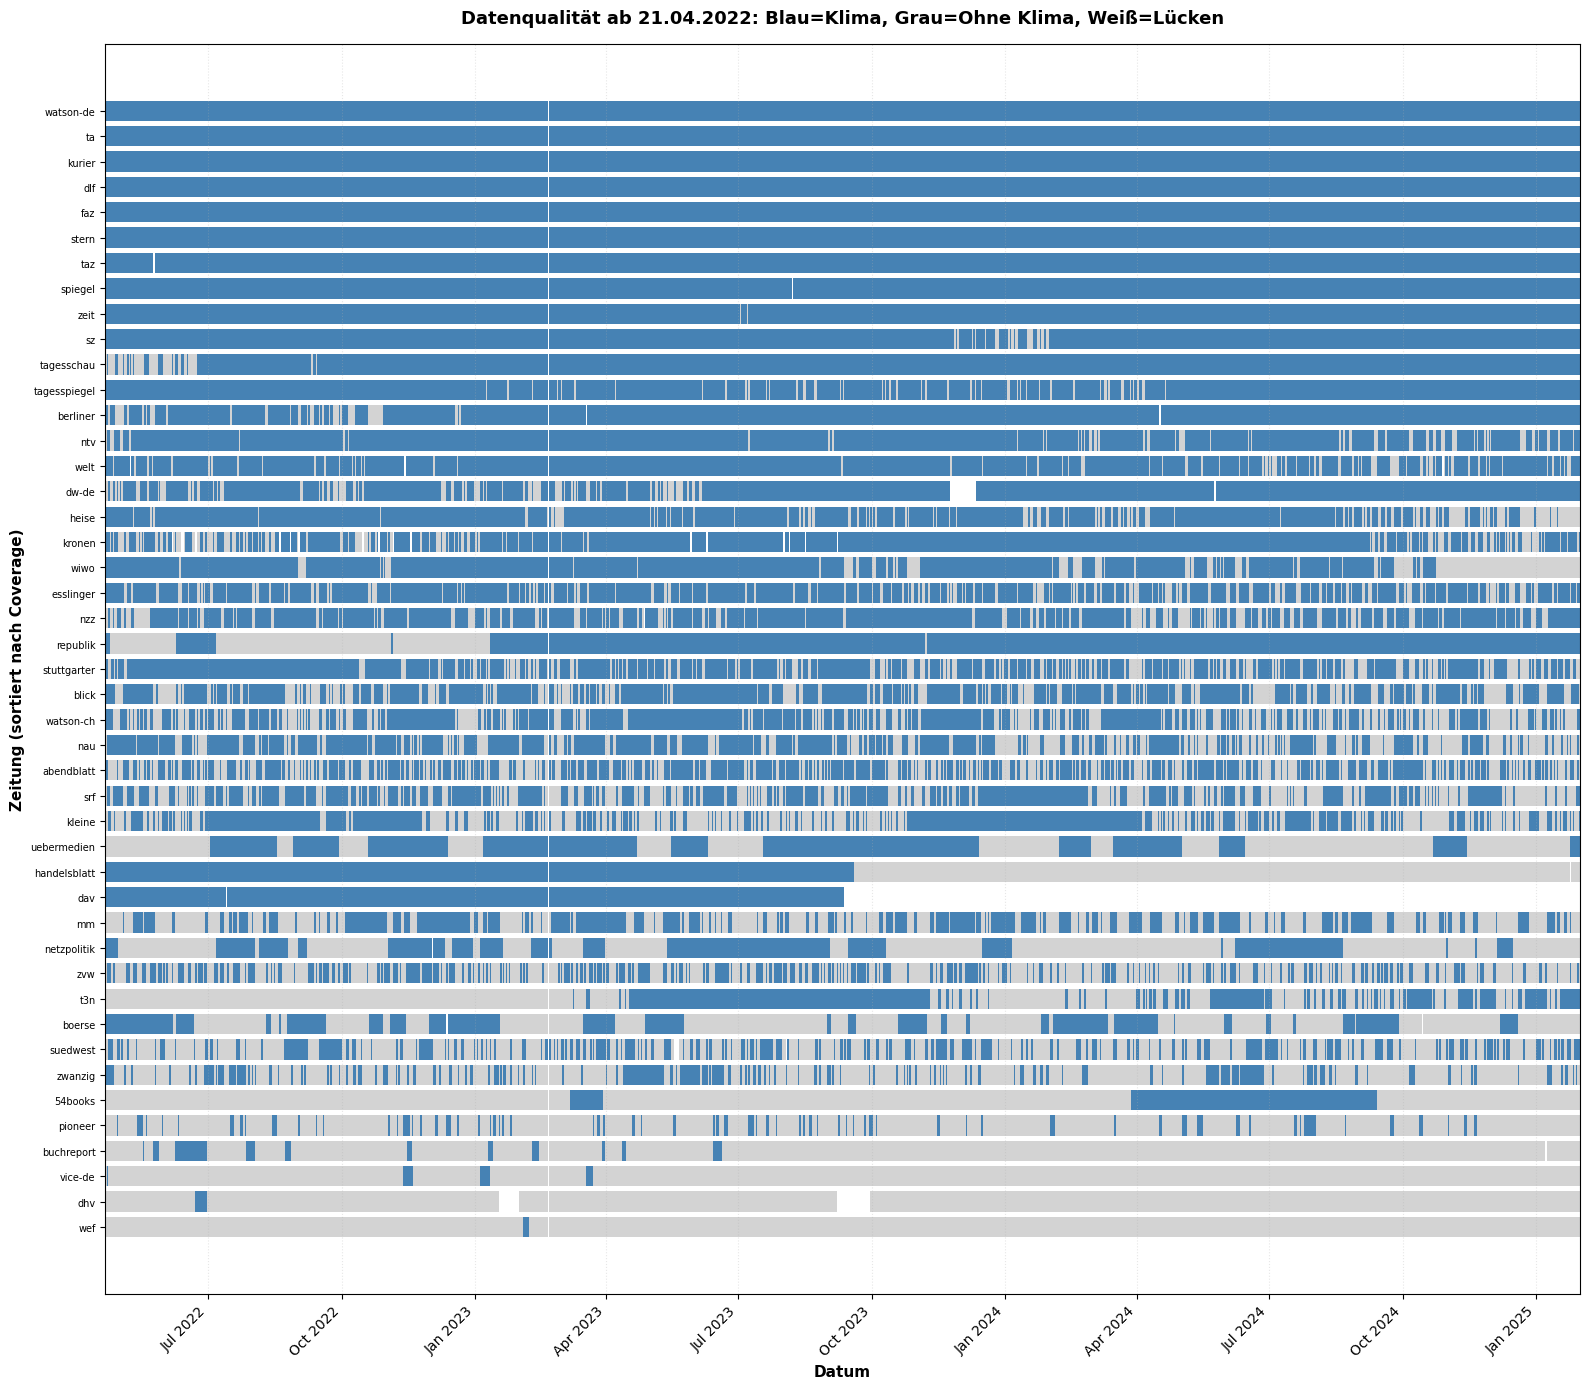

In [13]:
# Zelle 12: Große Visualisierung - Zeitungen über Zeit mit Lücken
date_min = cutoff_date
date_max = metadata['data_published'].max()
all_dates = pd.date_range(start=date_min, end=date_max, freq='D')

fig, ax = plt.subplots(figsize=(16, 14))
y_pos = 0

for np_name in newspapers_sorted:
    np_meta = metadata[metadata['newspaper_name'] == np_name]
    np_meta = np_meta[np_meta['data_published'] >= date_min]

    crawled_dates = set(np_meta['data_published'].dt.date)
    klima_dates = set(np_meta[np_meta['has_klima']]['data_published'].dt.date)

    for d in all_dates:
        if d.date() in klima_dates:
            ax.barh(y_pos, 1, left=d, height=0.8, color='steelblue', edgecolor='none')
        elif d.date() in crawled_dates:
            ax.barh(y_pos, 1, left=d, height=0.8, color='lightgray', edgecolor='none')
        # Weiß = Lücke (nichts plotten)

    y_pos += 1

ax.set_yticks(range(len(newspapers_sorted)))
ax.set_yticklabels(newspapers_sorted, fontsize=7)
ax.set_xlabel('Datum', fontsize=11, fontweight='bold')
ax.set_ylabel('Zeitung (sortiert nach Coverage)', fontsize=11, fontweight='bold')
ax.set_title('Datenqualität ab 21.04.2022: Blau=Klima, Grau=Ohne Klima, Weiß=Lücken',
             fontsize=13, fontweight='bold', pad=15)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
ax.set_xlim(date_min, date_max)
ax.grid(axis='x', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

## 5. Erkenntnisse - Datenqualität ab 21.04.2022

### Coverage-Statistik

**Analysezeitraum**: 21.04.2022 bis heute  
**Erwartete Tage**: [wird aus Daten berechnet]

**Zeitungen nach Coverage:**
- **> 90% Coverage**: [N Zeitungen] → Konsistente Datenerfassung, empfohlen für Analyse
- **70-90% Coverage**: [M Zeitungen] → Mittlere Qualität, ggf. verwendbar mit Vorsicht
- **< 70% Coverage**: [K Zeitungen] → Viele Lücken, Ausschluss empfohlen

### Beobachtungen aus Visualisierung

Die Visualisierung zeigt:
- Welche Zeitungen durchgehend erfasst wurden (wenig weiße Lücken)
- Welche Zeitungen sporadische Ausfälle haben
- Welche Zeitungen sehr unvollständig sind

### Empfehlung für nächste Schritte

1. **Zeitungs-Filter**: Nur Zeitungen mit > 90% Coverage verwenden
2. **Sprachfilter**: Zusätzlich nur deutsche Zeitungen (keine englischen wie BBC, CNN, etc.)
3. **Suffix-Analyse**: Häufigste deutsche Klima-Komposita identifizieren
4. **Zeitfilter**: Ab 21.04.2022 für konsistente Datenbasis

### Nächstes Notebook

**03_Suffix_Analyse.ipynb**: Welche deutschen Klima-Komposita sind am häufigsten?